In [1]:
#hide
from utils import *


# Image classification

## From dogs and cats, to pet breeds

In [2]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)

In [3]:
from nbdev.showdoc import *

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#11) [Path('fuzzy_tiger.jpg'),Path('cupid-cave.jpeg'),Path('models'),Path('tmp'),Path('annotations'),Path('image_gen'),Path('small-256'),Path('crappy'),Path('images'),Path('small-96')...]

In [6]:
(path/"images").ls()

(#7395) [Path('images/Siamese_257.jpg'),Path('images/miniature_pinscher_66.jpg'),Path('images/wheaten_terrier_125.jpg'),Path('images/Bombay_110.jpg'),Path('images/american_pit_bull_terrier_135.jpg'),Path('images/basset_hound_62.jpg'),Path('images/shiba_inu_200.jpg'),Path('images/great_pyrenees_86.jpg'),Path('images/Siamese_141.jpg'),Path('images/staffordshire_bull_terrier_75.jpg')...]

In [7]:
fname = (path/"images").ls()[0]

In [8]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Siamese']

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

## Presizing

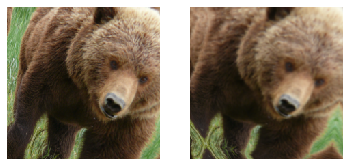

In [10]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and debugging a DataBlock

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/ndim1/.fastai/data/oxford-iiit-pet/images/Persian_217.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=300x226
  Pipeline: partial -> Categorize
    starting from
      /home/ndim1/.fastai/data/oxford-iiit-pet/images/Persian_217.jpg
    applying partial gives
      Persian
    applying Categorize gives
      TensorCategory(7)

Final sample: (PILImage mode=RGB size=300x226, TensorCategory(7))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=300x226, 

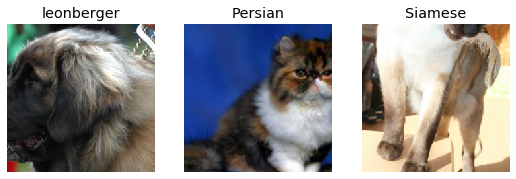

In [11]:
# dls.show_batch(nrows=1, ncols=3)
pets.summary(path/"images", show_batch=True, nrows=1, ncols=3)

In [12]:

def join_group_single(l_rank:int, ws:int, path):
    '''Join the current process to a PyTorch distributed group.
    Todo -- parameterize all currently hardcoded values.
    '''
    def starred_imports(modules):
        for mod in modules:
            m = __import__(mod, fromlist=['*'])
            
            if hasattr(m, '__all__'): all_names = m.__all__
            else: all_names = [n for n in dir(m) if not n.startswith('_')]

            globals().update({n: getattr(m, n) for n in all_names})

    import os, torch
    starred_imports(['utils', 'fastai2.data', 'fastai2.vision.all', 'fastai2.distributed'])
    # from utils import *
    # from fastai2.vision.all import *
    
    def build_and_train_learner(path, rank):
        pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                     get_items=get_image_files, 
                     splitter=RandomSplitter(seed=42),
                     get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                     item_tfms=Resize(460),
                     batch_tfms=aug_transforms(size=224, min_scale=0.75))
        dls = pets.dataloaders(path/"images")
        learn = cnn_learner(dls, resnet34, metrics=error_rate).to_distributed(rank)
        learn.fine_tune(2)
        return learn    

    g_rank, gpu = l_rank, l_rank
    print(f"[{os.getpid()}] rank: {l_rank}, world_size: {ws} path: {path}")    

    os.environ["RANK"] = str(g_rank) # Global rank
    os.environ["LOCAL_RANK"] = str(l_rank) # Local rank
    os.environ["MASTER_ADDR"] = "127.0.0.1"
    os.environ["MASTER_PORT"] = str(29500)
    os.environ["WORLD_SIZE"] = str(ws)
    os.environ["OMP_NUM_THREADS"] = str(1) # See https://github.com/pytorch/pytorch/pull/22501

    if ws > 0: torch.distributed.init_process_group(backend='nccl', init_method='env://')
        
    torch.cuda.set_device(gpu)
    device = torch.device(f"cuda:{gpu}")
    x = torch.tensor([1,2,3]).to(device)
    print(f"[{os.getpid()}] x: {x}")
    
    r = build_and_train_learner(path, l_rank) # fn(*fn_args, **fn_kwargs)

    if torch.distributed.is_initialized():
        print(f"rank {l_rank} Tearing down torch DDP.")
        torch.distributed.destroy_process_group()
        
    return r



In [13]:
import multiprocess as mp
mp.set_start_method('spawn', force=True)
from fastai2.distributed import *

wsize = 3
processes = []

for rank in range(1, wsize):
    p = mp.Process(target=join_group_single, args=(rank, wsize, path))
    p.start()
    processes.append(p)

join_group_single(0, wsize, path)

for p in processes:
    p.join()


[31088] rank: 0, world_size: 3 path: /home/ndim1/.fastai/data/oxford-iiit-pet
[31088] x: tensor([1, 2, 3], device='cuda:0')


epoch,train_loss,valid_loss,error_rate,time
0,2.603657,0.345495,0.104801,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.597729,0.262874,0.085193,00:20
1,0.436500,0.227555,0.073698,00:20


rank 0 Tearing down torch DDP.


In [22]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.524764,0.308337,0.096752,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.509021,0.286369,0.086604,00:29
1,0.316168,0.211767,0.064276,00:30


In [1]:
%load_ext ippddp.Ddip
%makedip -a fastai_v2 -g all --verbose True

ModuleNotFoundError: No module named 'ipyparallel'

In [4]:
%%dip
from utils import *
from fastai2.vision.all import *

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [5]:
%%dip
path = untar_data(URLs.PETS)
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [4]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
with learn.distrib_ctx(): learn.fine_tune(2)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  error_rate  time    
0         2.610518    0.350609    0.108857    00:19                                      
epoch     train_loss  valid_loss  error_rate  time    
0         0.577607    0.255701    0.077079    00:20                                      
1         0.426910    0.229510    0.074375    00:20                                      


In [4]:
%autodip on

Auto Execution on DDP group: on, will run cell as %%dip


## Cross entropy loss

### Viewing activations and labels

In [6]:
x,y = dls.one_batch()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [7]:
y

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:4]: 
TensorCategory([ 3, 23, 33,  6,  9,  6, 18,  7, 25, 22,  3, 11, 35, 29, 15, 11,  4,  9,  5, 16,  8,  4, 21,  3,  8,  0, 17,  4, 19, 29, 20, 32, 20, 30, 21, 34, 26, 30, 27,  6,  3, 26, 22,  4, 34, 25,  4, 26,
        10, 16,  2,  9, 13, 23, 11, 34, 25,  6, 28, 28, 20, 14, 24, 27], device='cuda:0')

In [8]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:5]: 
tensor([1.6457e-05, 1.7945e-04, 5.0685e-05, 9.9772e-01, 9.2242e-04, 6.2212e-05, 3.5202e-04, 4.2887e-05, 1.6425e-05, 3.2728e-04, 1.4610e-05, 4.8687e-07, 4.0322e-07, 3.5798e-06, 5.4641e-07, 6.0772e-07,
        4.6200e-06, 1.3336e-06, 6.4094e-07, 2.1509e-06, 2.1101e-06, 1.1593e-06, 1.0570e-05, 1.5571e-06, 7.4166e-05, 3.0053e-06, 1.3373e-06, 7.0066e-05, 2.2804e-05, 6.0874e-06, 5.5026e-06, 1.4519e-05,
        4.0752e-05, 1.2552e-06, 1.2873e-05, 7.1461e-06, 3.2889e-06])

In [9]:
len(preds[0]),preds[0].sum()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:6]: (37, tensor(1.))

### Softmax

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

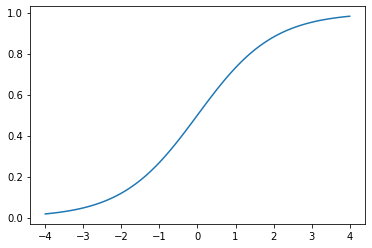

In [13]:
plot_function(torch.sigmoid, min=-4,max=4)

In [14]:
#hide
torch.random.manual_seed(42);

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [15]:
acts = torch.randn((6,2))*2
acts

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:9]: 
tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [16]:
acts.sigmoid()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:10]: 
tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [17]:
(acts[:,0]-acts[:,1]).sigmoid()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:11]: tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [18]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:12]: 
tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log likelihood

In [19]:
targ = tensor([0,1,0,1,1,0])

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [20]:
sm_acts

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:14]: 
tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [21]:
idx = range(6)
sm_acts[idx, targ]

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:15]: tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [22]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.99664,0.00336017,1,3,0.00336017
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [23]:
-sm_acts[idx, targ]

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:17]: tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [24]:
F.nll_loss(sm_acts, targ, reduction='none')

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:18]: tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the `log`

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

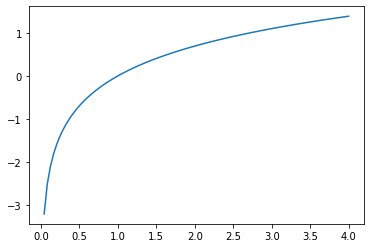

In [25]:
plot_function(torch.log, min=0,max=4)

In [26]:
loss_func = nn.CrossEntropyLoss()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [27]:
loss_func(acts, targ)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:21]: tensor(1.8045)

In [28]:
F.cross_entropy(acts, targ)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:22]: tensor(1.8045)

In [29]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:23]: tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

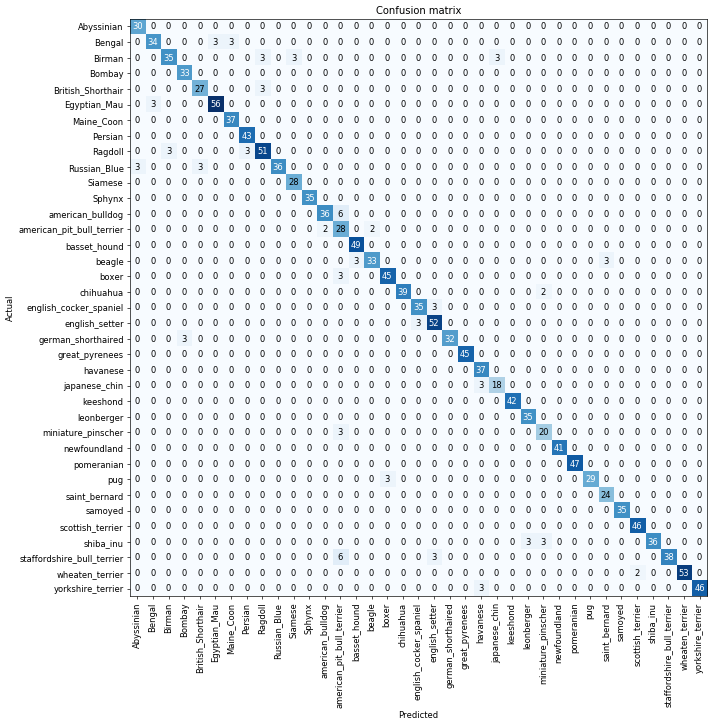

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [31]:
interp.most_confused(min_val=5)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:25]: 
[('american_bulldog', 'american_pit_bull_terrier', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6)]

## Improving our model

### Learning rate finder

In [7]:
%autodip on

Auto Execution on DDP group: on, will run cell as %%dip


In [6]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
with learn.distrib_ctx(): learn.fine_tune(1, base_lr=0.1)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  error_rate  time    
0         1.516229    1.983728    0.285328    00:18                                      
epoch     train_loss  valid_loss  error_rate  time    
0         3.174439    4.186678    0.626099    00:20                                      


In [8]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
with learn.distrib_ctx():
    lr_min,lr_steep = learn.lr_find()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Proc [14975] Caugth interrupt, sending SIGINT to engines....


TimeoutError: result not ready

In [7]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 4.37e-03


In [39]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
with learn.distrib_ctx():
    learn.fine_tune(2, base_lr=3e-3)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  error_rate  time    
0         2.308925    0.329384    0.111562    00:18                                      
epoch     train_loss  valid_loss  error_rate  time    
0         0.491358    0.285315    0.087897    00:20                                      
1         0.363765    0.239485    0.077079    00:20                                      


### Unfreezing and transfer learning

In [40]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
with learn.distrib_ctx():
    learn.fit_one_cycle(3, 3e-3)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  error_rate  time    
0         1.983373    0.302195    0.095335    00:18                                      
1         0.969812    0.243558    0.078431    00:18                                      
2         0.613324    0.234262    0.079108    00:18                                      


In [41]:
learn.unfreeze()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [7]:
with learn.distrib_ctx(): learn.lr_find()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


KeyboardInterrupt: 

In [43]:
with learn.distrib_ctx(): learn.fit_one_cycle(6, lr_max=1e-5)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  error_rate  time    
0         0.322914    0.219503    0.070994    00:19                                      
1         0.289729    0.210831    0.067613    00:20                                      
2         0.276951    0.213915    0.068966    00:20                                      
3         0.268284    0.199262    0.063556    00:21                                      
4         0.255594    0.193191    0.060852    00:20                                      
5         0.244572    0.198654    0.062204    00:20                                      


### Discriminative learning rates

In [45]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
with learn.distrib_ctx():
    learn.fit_one_cycle(3, 3e-3)
    learn.unfreeze()
    learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  error_rate  time    
0         2.063890    0.317400    0.102096    00:18                                      
1         0.987908    0.253483    0.076403    00:18                                      
2         0.625117    0.238908    0.079108    00:19                                      
epoch     train_loss  valid_loss  error_rate  time    
0         0.277055    0.230159    0.073022    00:20                                       
1         0.306170    0.219368    0.066937    00:20                                       
2         0.303155    0.217036    0.069642    00:20                                       
3         0.290494    0.209238    0.067613    00:20                                       
4         0.269638    0.202715    0.062880    00:20                                       
5         0.245388    0.203284    0.061528    00:20                                       
6         

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

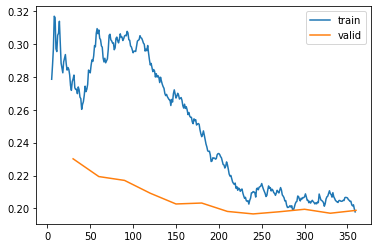

In [46]:
learn.recorder.plot_loss()

### Selecting the number of epochs

### Deeper architectures

In [ ]:
from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.427505,0.310554,0.098782,00:21
1,0.606785,0.302325,0.094723,00:22
2,0.409267,0.294803,0.091340,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.261121,0.274507,0.083897,00:26
1,0.296653,0.318649,0.084574,00:26
2,0.242356,0.253677,0.069012,00:26
3,0.150684,0.251438,0.065629,00:26
4,0.094997,0.239772,0.064276,00:26
5,0.061144,0.228082,0.054804,00:26


## Summary

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods is that it adds.
1. Look up the documentation for the Python pathlib module and try using a few methods of the Path class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a DataLoader?
1. What method does fastai provide to help you debug a DataBlock?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the "exp" and "softmax" columns of <<bear_softmax>> yourself (i.e. in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use torch.where to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the fine_tune method do?
1. In Jupyter notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python slice object interpreted when past as a learning rate to fastai?
1. Why is early stopping a poor choice when using one cycle training?
1. What is the difference between resnet 50 and resnet101?
1. What does to_fp16 do?

### Further research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Have a look on the forums and book website to see what other students have achieved with this dataset, and how they did it.